<a href="https://colab.research.google.com/github/Koltochen/Bioinformatics/blob/main/BostonGene_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В данной работе изучается аденокарценома желудка. Данный тип рака является 5-м по распростанённости и 3-м по причине смерти среди других видов. Употребление алкоголя, а также солёной, острой и пережаренной пищи ведёт к повышению вероятности развития аденокарценомы желудка. Кроме того курение, факторы окружающей среды, генетическая предрасположенность и инфекционные заболевания, в частности H. Pylori, указываются как причины развития рака.

При данном раке происходит чрезмерная эксперессия генов со следующими функциями:

1) Белки цитоскелета (COL1A1, COL1A2, COL3A1) 

2) Апоптоз и клеточное деление (CAS - Apoptosis Susceptibility Protein)

3) Развитие и инвазия опухоли (HMG-Y, Fibroblast collagenase inhibitor, Osteopontin)

В свою очередь пониженная экспрессия у генов с функциями:

1) Сопротивление лекарствам и детоксикация (Dihydrodiol dehydrogenase, MT-11)

2) Антиопухолевая активность (Ribonuclease A)

3) Клеточная адгезия, миграция и организация (EZR)

Суммарно эти изменения приводят к увеличению пролиферации, развитию опухоли и митостазированию.

Основная опасность данного заболевания заключается в схожести симптомов ранней стадии со многими другими заболеваниями ЖКТ, что приводит к тому, что редко удаётся идентифицироваать его на ранней стадии. А при более поздней стадии он начинает активно митостазировать в разные ограны (особенно, если это диффузный тип), кроме того данный тип не имеет чётких границ со здоровой тканью из-за чего приходится вырезать весь желудок :(

В публикации (https://www.nature.com/articles/nature13480) были выделены 4 подтипатипа рака желудка:

1)EBV - Подтип ассоциированный с Helicobacter Pylori и Epstein–Barr virus. Отличается гиперметилированием ДНК, в особенности гена CDKN2A. Из-за чего происходит ингибирование его эксперессии, и как сдедствие потеря контроля клеточного цикла. Другой характерной особенностью являются частые мутации в PIK3CA. Также для защиты от иммунной системы данный подтип эксперессирует на поверхности PD-L1/2

2)MSI - Подтип с повышенной микросателитной нестабильностью. Аналогично EBV, наблюдается гиперметилирование ДНК, в частности инактивация гена MLH1, ответсвенного за коррестную репарацию ДНК (из-за его отсутвия и наблюдается микросателитная нестабильность)

3)GS - Подтип с низкой копийностью генов и высокой стабильностью хромосом. Составляет основу диффузных типов рака (73%). Мутации, соответствующие данному уподтипу: CDH1, RHOA, ARID1A. Кроме того для данного подтипа характерно слияние генов CLDN18 и ARHGAP26, ответсвенных за плотные межклеточные контакты и клеточную подвижность, соответсвенно. Геномно стабильный подтип проявлял повышенную экспрессию путей клеточной адгезии.

4)CIN - Подтип с высокой копийностью генов и низкой стабильностью хромосом. Чаще всего расположен в соединение пищевода с желудком. В данном подтипе широко распростанена мутация TP53 (71%). На поверхности клеток наблюдается повышенная экспрессия RTK, т.е. сигналинг происходит преимущественно с помощью данных рецепторов

In [80]:
import pandas as pd
import numpy as np
import gzip
import scipy.optimize as sc
from scipy import stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [81]:
with gzip.open('TCGA-STAD.htseq_fpkm.tsv.gz', 'r') as f:
  df = pd.read_csv(f, sep ='\t')

In [82]:
df.head()

,Ensembl_ID,TCGA-D7-5577-01A,TCGA-D7-6818-01A,TCGA-BR-4280-01A,TCGA-D7-8572-01A,TCGA-VQ-A91Z-01A,TCGA-HU-A4HD-01A,TCGA-D7-8573-01A,TCGA-BR-7959-01A,TCGA-BR-8679-01A,TCGA-CG-5726-01A,TCGA-BR-6453-01A,TCGA-BR-A4QL-01A,TCGA-VQ-AA6A-01A,TCGA-HF-7132-01A,TCGA-BR-A4IV-01A,TCGA-CG-5718-01A,TCGA-BR-8296-01A,TCGA-R5-A7ZR-01A,TCGA-HU-A4GY-11A,TCGA-BR-8680-01A,TCGA-VQ-A8P2-01A,TCGA-CD-8533-01A,TCGA-IP-7968-11A,TCGA-RD-A8N2-01A,TCGA-VQ-A92D-01A,TCGA-CG-5721-11A,TCGA-HU-A4GT-01A,TCGA-ZA-A8F6-01A,TCGA-D7-A74A-01A,TCGA-IN-A7NR-01A,TCGA-HU-A4H2-01A,TCGA-BR-6456-01A,TCGA-CG-4442-01A,TCGA-CD-8524-01A,TCGA-VQ-A8PO-01A,TCGA-BR-7717-01A,TCGA-CG-4475-01A,TCGA-BR-4369-01A,TCGA-HU-A4GH-11A,...,TCGA-RD-A8N4-01A,TCGA-IN-A6RJ-01A,TCGA-CG-5723-01A,TCGA-VQ-AA6D-01A,TCGA-F1-6874-01A,TCGA-CG-4304-01A,TCGA-VQ-A923-01A,TCGA-CG-5733-11A,TCGA-VQ-A8PF-01A,TCGA-BR-8361-01A,TCGA-BR-8690-01A,TCGA-HJ-7597-01A,TCGA-RD-A7BT-01A,TCGA-CG-5720-11A,TCGA-MX-A5UJ-01A,TCGA-VQ-A91Q-01A,TCGA-D7-5578-01A,TCGA-SW-A7EB-01A,TCGA-HU-A4GU-01A,TCGA-D7-6521-01A,TCGA-IN-AB1V-01A,TCGA-HF-7134-01A,TCGA-CD-A48C-01A,TCGA-HU-8610-01A,TCGA-BR-8373-01A,TCGA-EQ-8122-01A,TCGA-B7-5818-01A,TCGA-D7-A6F2-01A,TCGA-RD-A7C1-01A,TCGA-HF-7131-01A,TCGA-CD-5799-01A,TCGA-VQ-A91S-01A,TCGA-HU-A4GY-01A,TCGA-HU-8608-01A,TCGA-CD-A489-01A,TCGA-BR-6566-01A,TCGA-IN-8663-11A,TCGA-BR-A4J6-01A,TCGA-BR-8286-01A,TCGA-CD-8529-01A
0,ENSG00000242268.2,0.000000,0.000000,0.000000,0.116304,0.000000,0.000000,0.196553,0.000000,0.000000,0.000000,0.000000,0.000000,0.025747,0.000000,0.000000,0.000000,0.312898,0.117003,0.034894,0.065701,0.035842,0.059060,0.037077,0.088984,0.000000,0.000000,0.000000,0.030041,0.195673,0.000000,0.040667,0.000000,0.103966,0.117637,0.000000,0.000000,0.000000,0.000000,0.087015,...,0.071320,0.067161,0.000000,0.000000,0.034431,0.109055,0.113539,0.000000,0.000000,0.000000,0.349197,0.082584,0.000000,0.000000,0.101835,0.000000,0.000000,0.000000,0.000000,0.030281,0.000000,0.00000,0.023201,0.000000,0.000000,0.088569,0.000000,0.029170,0.642290,0.000000,0.000000,0.000000,0.027588,0.000000,0.272296,0.000000,0.000000,0.046976,0.124435,0.028077
1,ENSG00000270112.3,0.000000,0.009555,0.000000,0.020856,0.060100,0.002479,0.016600,0.002234,0.003385,0.000000,0.011753,0.016503,0.007191,0.000000,0.002773,0.000000,0.088790,0.000000,0.004892,0.004656,0.000000,0.012493,0.000000,0.004239,0.006476,0.000000,0.000000,0.004206,0.000000,0.000000,0.000000,0.000000,0.000000,0.020265,0.003841,0.000000,0.000000,0.000000,0.000000,...,0.010109,0.000000,0.000000,0.018186,0.028721,0.005230,0.004092,0.000000,0.000000,0.000000,0.013640,0.034952,0.008545,0.000000,0.010939,0.042374,0.000000,0.000000,0.000000,0.000000,0.003983,0.00000,0.000000,0.000000,0.026776,0.003165,0.000000,0.000000,0.369383,0.000000,0.004721,0.006213,0.007709,0.000000,0.000000,0.000000,0.000000,0.000000,0.008988,0.003929
2,ENSG00000167578.15,3.009860,2.601618,1.621811,1.251908,1.569297,1.449952,1.315607,1.430888,1.537194,1.836273,2.848684,1.490224,2.208142,2.105817,1.820941,3.117007,2.548022,2.441854,1.143866,1.750760,1.037358,1.760805,1.430180,0.930851,1.225897,2.689482,1.558169,2.023616,2.404938,1.978388,2.142640,2.285890,1.007680,3.271942,2.274661,2.246728,2.387475,1.983217,1.297211,...,1.319491,1.856428,2.727122,1.468977,1.842890,2.044319,2.964117,2.829864,2.455026,1.517085,2.973128,1.996018,1.806474,2.757839,2.028487,1.923087,2.492408,2.134615,1.417895,2.578408,2.203971,1.99970,2.730489,2.101663,1.444969,2.256842,2.488889,1.803217,2.374202,2.586253,2.431977,1.627396,2.456258,2.125108,1.937515,2.211638,1.728039,2.583241,2.118506,2.373501
3,ENSG00000273842.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.322034,0.371785,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.362778,0.000000,

Существуют несколько единиц измерения откартированных ридов. Самая простая - это counts. Она просто показывает, сколько ридов откартированлось на определённый участок. Более продвинутой единицей измерения является RPKM - Reads Per Kilobase Million. Здесть происходит нормировка каунтов на количество пришедших ридов суммарно, т.е. даёт распределение по долям приходящим с разных участков. А также имеется деление на длину участка, так как логично, что чем больше участок тем больше, ридов он даст (при том же уровне экспрессии). Очень похожей единицей измерения является FPKM. В ней происходят те же нормировки, с той лишь разницей, что теперь измеряются не риды, а фрагменты. Это различие играет роль в случае paired-end секвенирования, при котором 1 фрагмент (т.е. 1 случай транскрипции) может быть отмечен с обоих концов, а может лишь с одного. Но в любом случае надо приписывать  даннному гену 1 акт транскрипции. Именно поэтому считаются фрагменты, а не риды.

In [83]:
import re
symbols = pd.read_csv('gencode.v22.annotation.gene.probeMap', sep = (r'\t')) 
symbols.head(10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,id,gene,chrom,chromStart,chromEnd,strand
0,ENSG00000223972.5,DDX11L1,chr1,11869,14409,+
1,ENSG00000227232.5,WASH7P,chr1,14404,29570,-
2,ENSG00000278267.1,MIR6859-3,chr1,17369,17436,-
3,ENSG00000243485.3,RP11-34P13.3,chr1,29554,31109,+
4,ENSG00000274890.1,MIR1302-9,chr1,30366,30503,+
5,ENSG00000237613.2,FAM138A,chr1,34554,36081,-
6,ENSG00000268020.3,OR4G4P,chr1,52473,53312,+
7,ENSG00000240361.1,OR4G11P,chr1,62948,63887,+
8,ENSG00000186092.4,OR4F5,chr1,69091,70008,+
9,ENSG00000238009.5,RP11-34P13.7,chr1,89295,133723,-


In [84]:
sym2 = pd.DataFrame(data = symbols['gene'], index = symbols['id'], copy = True)
sym2['gene'][::] = list(symbols['gene'])
sym2.head(5)

sym_dict = sym2.to_dict()
sym_dict['gene']['ENSG00000242268.2']

'RP11-368I23.2'

In [85]:
df['Ensembl_ID'] = df['Ensembl_ID'].replace(sym_dict['gene'])
df.head()

,Ensembl_ID,TCGA-D7-5577-01A,TCGA-D7-6818-01A,TCGA-BR-4280-01A,TCGA-D7-8572-01A,TCGA-VQ-A91Z-01A,TCGA-HU-A4HD-01A,TCGA-D7-8573-01A,TCGA-BR-7959-01A,TCGA-BR-8679-01A,TCGA-CG-5726-01A,TCGA-BR-6453-01A,TCGA-BR-A4QL-01A,TCGA-VQ-AA6A-01A,TCGA-HF-7132-01A,TCGA-BR-A4IV-01A,TCGA-CG-5718-01A,TCGA-BR-8296-01A,TCGA-R5-A7ZR-01A,TCGA-HU-A4GY-11A,TCGA-BR-8680-01A,TCGA-VQ-A8P2-01A,TCGA-CD-8533-01A,TCGA-IP-7968-11A,TCGA-RD-A8N2-01A,TCGA-VQ-A92D-01A,TCGA-CG-5721-11A,TCGA-HU-A4GT-01A,TCGA-ZA-A8F6-01A,TCGA-D7-A74A-01A,TCGA-IN-A7NR-01A,TCGA-HU-A4H2-01A,TCGA-BR-6456-01A,TCGA-CG-4442-01A,TCGA-CD-8524-01A,TCGA-VQ-A8PO-01A,TCGA-BR-7717-01A,TCGA-CG-4475-01A,TCGA-BR-4369-01A,TCGA-HU-A4GH-11A,...,TCGA-RD-A8N4-01A,TCGA-IN-A6RJ-01A,TCGA-CG-5723-01A,TCGA-VQ-AA6D-01A,TCGA-F1-6874-01A,TCGA-CG-4304-01A,TCGA-VQ-A923-01A,TCGA-CG-5733-11A,TCGA-VQ-A8PF-01A,TCGA-BR-8361-01A,TCGA-BR-8690-01A,TCGA-HJ-7597-01A,TCGA-RD-A7BT-01A,TCGA-CG-5720-11A,TCGA-MX-A5UJ-01A,TCGA-VQ-A91Q-01A,TCGA-D7-5578-01A,TCGA-SW-A7EB-01A,TCGA-HU-A4GU-01A,TCGA-D7-6521-01A,TCGA-IN-AB1V-01A,TCGA-HF-7134-01A,TCGA-CD-A48C-01A,TCGA-HU-8610-01A,TCGA-BR-8373-01A,TCGA-EQ-8122-01A,TCGA-B7-5818-01A,TCGA-D7-A6F2-01A,TCGA-RD-A7C1-01A,TCGA-HF-7131-01A,TCGA-CD-5799-01A,TCGA-VQ-A91S-01A,TCGA-HU-A4GY-01A,TCGA-HU-8608-01A,TCGA-CD-A489-01A,TCGA-BR-6566-01A,TCGA-IN-8663-11A,TCGA-BR-A4J6-01A,TCGA-BR-8286-01A,TCGA-CD-8529-01A
0,RP11-368I23.2,0.000000,0.000000,0.000000,0.116304,0.000000,0.000000,0.196553,0.000000,0.000000,0.000000,0.000000,0.000000,0.025747,0.000000,0.000000,0.000000,0.312898,0.117003,0.034894,0.065701,0.035842,0.059060,0.037077,0.088984,0.000000,0.000000,0.000000,0.030041,0.195673,0.000000,0.040667,0.000000,0.103966,0.117637,0.000000,0.000000,0.000000,0.000000,0.087015,...,0.071320,0.067161,0.000000,0.000000,0.034431,0.109055,0.113539,0.000000,0.000000,0.000000,0.349197,0.082584,0.000000,0.000000,0.101835,0.000000,0.000000,0.000000,0.000000,0.030281,0.000000,0.00000,0.023201,0.000000,0.000000,0.088569,0.000000,0.029170,0.642290,0.000000,0.000000,0.000000,0.027588,0.000000,0.272296,0.000000,0.000000,0.046976,0.124435,0.028077
1,RP11-742D12.2,0.000000,0.009555,0.000000,0.020856,0.060100,0.002479,0.016600,0.002234,0.003385,0.000000,0.011753,0.016503,0.007191,0.000000,0.002773,0.000000,0.088790,0.000000,0.004892,0.004656,0.000000,0.012493,0.000000,0.004239,0.006476,0.000000,0.000000,0.004206,0.000000,0.000000,0.000000,0.000000,0.000000,0.020265,0.003841,0.000000,0.000000,0.000000,0.000000,...,0.010109,0.000000,0.000000,0.018186,0.028721,0.005230,0.004092,0.000000,0.000000,0.000000,0.013640,0.034952,0.008545,0.000000,0.010939,0.042374,0.000000,0.000000,0.000000,0.000000,0.003983,0.00000,0.000000,0.000000,0.026776,0.003165,0.000000,0.000000,0.369383,0.000000,0.004721,0.006213,0.007709,0.000000,0.000000,0.000000,0.000000,0.000000,0.008988,0.003929
2,RAB4B,3.009860,2.601618,1.621811,1.251908,1.569297,1.449952,1.315607,1.430888,1.537194,1.836273,2.848684,1.490224,2.208142,2.105817,1.820941,3.117007,2.548022,2.441854,1.143866,1.750760,1.037358,1.760805,1.430180,0.930851,1.225897,2.689482,1.558169,2.023616,2.404938,1.978388,2.142640,2.285890,1.007680,3.271942,2.274661,2.246728,2.387475,1.983217,1.297211,...,1.319491,1.856428,2.727122,1.468977,1.842890,2.044319,2.964117,2.829864,2.455026,1.517085,2.973128,1.996018,1.806474,2.757839,2.028487,1.923087,2.492408,2.134615,1.417895,2.578408,2.203971,1.99970,2.730489,2.101663,1.444969,2.256842,2.488889,1.803217,2.374202,2.586253,2.431977,1.627396,2.456258,2.125108,1.937515,2.211638,1.728039,2.583241,2.118506,2.373501
3,AC104183.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.322034,0.371785,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.362778,0.000000,0.000000,0.000000,0.498905,0

In [86]:
print(len(df))

60483


** Пункт 5**

Как я понял, для исследоания на батч-эффект надо выбрать небиологический параметр и посмотреть будут ли данные кластеризоваться на его основе. Обычно этим параметром являются лаборатории, проводящие эксперимент. Но тут везде исседования проводил Nationwide Children's Hospital. Так что я решил просто для примера посмотреть, будет ли влияние типа аденокарценомы (колонка primary_diagnosis.diagnoses)

In [87]:
with gzip.open('TCGA-STAD.GDC_phenotype.tsv.gz', 'r') as f:
  phen = pd.read_csv(f, sep ='\t')
phen.head(5)

,submitter_id.samples,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,anatomic_neoplasm_subdivision_other,antireflux_treatment,barretts_esophagus,batch_number,bcr,bcr_followup_barcode,bcr_followup_uuid,submitter_id,city_of_procurement,country_of_procurement,day_of_dcc_upload,day_of_form_completion,days_to_additional_surgery_locoregional_procedure,days_to_additional_surgery_metastatic_procedure,days_to_initial_pathologic_diagnosis,days_to_new_tumor_event_after_initial_treatment,family_history_of_stomach_cancer,file_uuid,followup_case_report_form_submission_reason,followup_treatment_success,h_pylori_infection,history_of_neoadjuvant_treatment,informed_consent_verified,lost_follow_up,lymph_node_examined_count,month_of_dcc_upload,month_of_form_completion,neoplasm_histologic_grade,new_neoplasm_event_occurrence_anatomic_site,new_neoplasm_occurrence_anatomic_site_text,new_tumor_event_after_initial_treatment,number_of_lymphnodes_positive_by_he,number_of_relatives_with_stomach_cancer,other_dx,...,age_at_diagnosis.diagnoses,classification_of_tumor.diagnoses,days_to_diagnosis.diagnoses,days_to_last_follow_up.diagnoses,icd_10_code.diagnoses,last_known_disease_status.diagnoses,morphology.diagnoses,primary_diagnosis.diagnoses,prior_malignancy.diagnoses,prior_treatment.diagnoses,progression_or_recurrence.diagnoses,site_of_resection_or_biopsy.diagnoses,synchronous_malignancy.diagnoses,tissue_or_organ_of_origin.diagnoses,tumor_grade.diagnoses,tumor_stage.diagnoses,year_of_diagnosis.diagnoses,disease_type,alcohol_history.exposures,primary_site,name.project,project_id.project,releasable.project,bcr_id.tissue_source_site,code.tissue_source_site,name.tissue_source_site,project.tissue_source_site,days_to_collection.samples,days_to_sample_procurement.samples,initial_weight.samples,intermediate_dimension.samples,is_ffpe.samples,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples
0,TCGA-CG-5720-01A,NaN,NaN,NaN,NaN,71.0,NaN,NaN,No,95.85.0,Nationwide Children's Hospital,NaN,NaN,TCGA-CG-5720,Hamburg,Germany,22,NaN,NaN,NaN,0.0,NaN,NO,F815D67D-0856-47FD-A324-476B74D8DE45,NaN,NaN,NaN,No,YES,NaN,60.0,12,NaN,G3,NaN,NaN,NaN,0.0,0.0,No,...,26176.0,not reported,0.0,NaN,C16.0,not reported,8140/3,"Adenocarcinoma, NOS",no,No,not reported,"Cardia, NOS",No,"Cardia, NOS",not reported,stage ib,2003.0,Adenomas and Adenocarcinomas,Not Reported,Stomach,Stomach Adenocarcinoma,TCGA-STAD,False,IGC,CG,Indivumed,Stomach adenocarcinoma,NaN,NaN,NaN,0.6,False,0.9,NaN,NaN,Primary Tumor,1,0.6,released,Not Reported
1,TCGA-CG-5720-11A,NaN,NaN,NaN,NaN,71.0,NaN,NaN,No,95.85.0,Nationwide Children's Hospital,NaN,NaN,TCGA-CG-5720,Hamburg,Germany,22,NaN,NaN,NaN,0.0,NaN,NO,F815D67D-0856-47FD-A324-476B74D8DE45,NaN,NaN,NaN,No,YES,NaN,60.0,12,NaN,G3,NaN,NaN,NaN,0.0,0.0,No,...,26176.0,not reported,0.0,NaN,C16.0,not reported,8140/3,"Adenocarcinoma, NOS",no,No,not reported,"Cardia, NOS",No,"Cardia, NOS",not reported,stage ib,2003.0,Adenomas and Adenocarcinomas,Not Reported,Stomach,Stomach Adenocarcinoma,TCGA-STAD,False,IGC,CG,Indivumed,Stomach adenocarcinoma,NaN,NaN,NaN,0.8,False,1.6,NaN,NaN,Solid Tissue Normal,11,0.4,released,Not Reported
2,TCGA-VQ-A8PX-01A,NaN,NaN,NaN,NaN,51.0,Gastric stump,NO,No,427.44.0,Nationwide Children's Hospital,TCGA-VQ-A8PX-F64675,5BD47306-2943-4E22-9ED8-B47637620DE3,TCGA-VQ-A8PX,Barretos,Sao Paulo,22,9.0,NaN,NaN,0.0,NaN,NO,A58619D0-D819-4585-ADA0-2D3B02DB720C,Scheduled Follow-up Submission,Complete Remission/Response,No,No,YES,NO,24.0,12,9.0,G2,NaN,NaN,NO,0.0,NaN,No,...,18902.0,not reported,0.0,1964.0,C16.9,not reported,8144/3,"Adenocarcinoma, intestinal type",no,No,not reported,"Stomach, NOS",No,"Stomach, NOS",not reported,stage ia,2009.0,Adenomas and Adenocarcinomas,Not Reported,Stomach,Stomach Adenocarcinoma,TCG

In [88]:
names1 = set()
for i in df.columns:
  names1.add(i)
name_type = phen[['submitter_id.samples', 'primary_diagnosis.diagnoses']]
for i in range(len(name_type)):
  if name_type['submitter_id.samples'][i] not in names1:
    name_type = name_type.drop(i, axis = 0)
name_type

,submitter_id.samples,primary_diagnosis.diagnoses
0,TCGA-CG-5720-01A,"Adenocarcinoma, NOS"
1,TCGA-CG-5720-11A,"Adenocarcinoma, NOS"
2,TCGA-VQ-A8PX-01A,"Adenocarcinoma, intestinal type"
3,TCGA-BR-A4CR-01A,"Adenocarcinoma, NOS"
4,TCGA-MX-A663-01A,"Adenocarcinoma, NOS"
...,...,...
534,TCGA-ZQ-A9CR-01A,Tubular adenocarcinoma
535,TCGA-IN-AB1X-01A,"Adenocarcinoma, NOS"
536,TCGA-IN-AB1X-11A,"Adenocarcinoma, NOS"
537,TCGA-VQ-A8E0-01A,"Adenocarcinoma, intestinal type"


In [89]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [90]:
pca = df.copy()
pca = pca.drop(labels = 'Ensembl_ID', axis = 1)
pcat = pca.transpose()
#Центрируем 
pcat = pcat.sub(pcat.mean(axis = 1), axis = 'index')
for i in pcat.columns:
  pcat[i] = pcat[i]/pcat[i].std()
pcat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60443,60444,60445,60446,60447,60448,60449,60450,60451,60452,60453,60454,60455,60456,60457,60458,60459,60460,60461,60462,60463,60464,60465,60466,60467,60468,60469,60470,60471,60472,60473,60474,60475,60476,60477,60478,60479,60480,60481,60482
TCGA-D7-5577-01A,-7.128942,-12.763919,4.486066,-6.894845,5.003077,7.508756,-7.590074,-3.295295,13.172072,-3.975837,-7.794860,-10.977224,-7.522832,8.759064,-2.619833,-0.544061,3.254121,-4.498281,-9.073291,3.902473,-7.150159,-7.900210,-12.101154,-3.107140,-9.365344,0.734106,-0.079000,-12.171783,-5.230693,-1.537488,-5.801399,-4.617423,-8.991259,-0.195396,-6.965411,1.305640,-11.464690,-13.285978,-11.314267,-3.629993,...,-3.597106,-7.397033,4.767742,-6.126748,-2.850393,-5.724161,-4.998484,8.381603,-5.883637,1.745921,-11.006382,-8.489789,-2.446526,4.321226,-4.386466,-2.190153,-3.419262,-0.810472,2.180596,-11.006382,-11.712638,3.090915,-11.498067,-9.814906,-5.280784,-1.880185,-3.141928,-10.671942,-4.472512,-1.955232,-11.006382,-0.515498,-11.961990,-0.386273,-4.983694,7.394586,-2.701417,-7.115195,0.542427,-13.035377
TCGA-D7-6818-01A,-7.572174,-13.391977,3.589949,-7.323522,2.123297,6.647963,-8.061976,-2.403257,10.927140,-4.469010,-7.927646,-11.659717,-7.990553,8.436890,-2.939439,-0.649657,3.730081,-4.777955,-9.637410,3.855033,-7.594710,-8.391394,-12.853526,-3.481527,-9.947621,0.092403,0.745949,-12.928546,-6.093711,2.351558,-6.162092,-4.134370,-8.511090,0.406665,-7.490060,3.322152,-12.177490,-14.112015,-12.017715,-3.055926,...,-4.385280,-8.907101,2.369466,-6.507670,-3.027612,-5.306736,-5.309258,8.006759,-4.295970,1.537170,-11.690688,-9.017630,-0.926618,3.394822,-4.659188,-2.591423,-3.631849,-2.337414,1.133393,-11.690688,-12.440854,3.589070,-12.212943,-10.425134,-3.808997,-1.997083,-2.380198,-11.335455,-4.102507,-2.165710,-11.690688,1.961789,-12.705709,-0.277461,-5.293548,7.992081,-1.480388,-7.557572,0.754507,-13.845833
TCGA-BR-4280-01A,-7.352615,-13.164390,1.700993,-7.111172,3.805151,8.206852,-7.144412,-2.792729,12.160850,-5.140393,-7.763928,-11.321637,-7.758862,9.397829,-3.265049,-0.625424,3.139753,-4.334535,-9.357968,4.961684,-7.374497,-8.148081,-12.480831,-3.491357,-9.659184,2.667395,1.938614,-12.553675,-5.917020,-0.367692,-5.983419,-4.422042,-9.273362,1.187130,-6.873695,0.674059,-11.824397,-13.702829,-11.669255,-2.531203,...,-4.086110,-8.648835,3.712279,-6.318976,-2.939824,-5.295265,-5.155313,8.975617,-6.068237,3.834894,-11.351710,-8.756159,-2.594296,4.354566,-4.524093,-3.402740,-2.224138,0.880092,1.042305,-11.351710,-12.080125,1.129621,-11.858822,-10.122852,-5.446470,-1.939176,-3.240507,-10.635150,-4.612838,-2.131830,-11.351710,0.037483,-12.107883,-0.385486,-5.140058,5.845809,-2.846515,-7.338436,-0.883716,-13.190997
TCGA-D7-8572-01A,-7.659700,-15.367662,0.678777,-8.496502,3.984373,7.026677,-8.587945,-2.210824,10.945798,-3.657404,-7.564453,-13.527209,-9.270369,9.480071,-2.935916,-0.188826,3.591892,-5.543222,-10.362362,4.890984,-5.271294,-7.436405,-14.912225,-3.722229,-11.540894,2.156645,0.590397,-14.021965,-4.751055,-1.861678,-4.836514,-4.382601,-10.344832,-0.394328,-7.298177,2.407904,-14.127912,-15.398640,-13.942546,-1.367225,...,-5.009982,-8.294097,3.410784,-7.549978,-2.771844,-7.053872,-4.883503,9.074917,-6.883107,2.795115,-13.563140,-10.461949,-0.877319,4.429617,-3.191009,-1.895930,-3.696230,-0.146217,0.090171,-13.563140,-12.688544,1.124739,-14.169043,-11.567888,-5.840098,-0.286554,-3.025140,-13.151011,-5.033417,-1.875470,-13.563140,0.066772,-13.728022,-0.493353,-4.568508,5.658907,-2.151243,-7.124329,-0.380460,-14.137657
TCGA-VQ-A91Z-01A,-7.808782,-12.940007,1.504302,-7.552360,1.903430,8.326915,-8.313888,-3.577822,11.157574,-4.984842,-7.754476,-12.024049,-8.240234,10.781811,-1.697430,-0.691242,2.745195,-4.927252,-9.060789,4.297992,-7.832022,-8.653600,-13.255160,-3.193087,-10.258455,1.308143,0.449861,-13.332524,-5.972379,2.095715,-6.354639,-4.935528,-9.848695,-0.428107,-4.979937,3.

In [91]:
pca_object = PCA(n_components=2)
principalComponents = pca_object.fit_transform(pcat)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,-112.784366,-3.768757
1,-38.117594,-34.428765
2,-62.324297,-11.576862
3,168.898485,19.218590
4,32.223985,-30.993916
...,...,...
402,-155.654152,25.728364
403,-292.395645,71.006671
404,-10.566325,-1.640237
405,124.579131,115.539084


In [92]:
finalDf = pd.concat([principalDf, pd.Series(df.columns[1:])], axis = 1)
finalDf.columns = ['principal component 1', 'principal component 2', 'submitter_id.samples']
finalDf

,principal component 1,principal component 2,submitter_id.samples
0,-112.784366,-3.768757,TCGA-D7-5577-01A
1,-38.117594,-34.428765,TCGA-D7-6818-01A
2,-62.324297,-11.576862,TCGA-BR-4280-01A
3,168.898485,19.218590,TCGA-D7-8572-01A
4,32.223985,-30.993916,TCGA-VQ-A91Z-01A
...,...,...,...
402,-155.654152,25.728364,TCGA-BR-6566-01A
403,-292.395645,71.006671,TCGA-IN-8663-11A
404,-10.566325,-1.640237,TCGA-BR-A4J6-01A
405,124.579131,115.539084,TCGA-BR-8286-01A


In [93]:
# finalDf, name_type = phen[['submitter_id.samples', 'primary_diagnosis.diagnoses']]
finalDf = pd.merge(finalDf, phen[['submitter_id.samples', 'primary_diagnosis.diagnoses']],  on= 'submitter_id.samples' )
finalDf.head()

,principal component 1,principal component 2,submitter_id.samples,primary_diagnosis.diagnoses
0,-112.784366,-3.768757,TCGA-D7-5577-01A,Tubular adenocarcinoma
1,-38.117594,-34.428765,TCGA-D7-6818-01A,"Carcinoma, diffuse type"
2,-62.324297,-11.576862,TCGA-BR-4280-01A,"Adenocarcinoma, NOS"
3,168.898485,19.218590,TCGA-D7-8572-01A,"Adenocarcinoma, NOS"
4,32.223985,-30.993916,TCGA-VQ-A91Z-01A,Tubular adenocarcinoma


In [94]:
se = set()
for i in finalDf['primary_diagnosis.diagnoses']:
  se.add(i)
print(se)

{'Papillary adenocarcinoma, NOS', 'Tubular adenocarcinoma', 'Adenocarcinoma with mixed subtypes', 'Adenocarcinoma, intestinal type', 'Adenocarcinoma, NOS', 'Mucinous adenocarcinoma', 'Carcinoma, diffuse type', 'Signet ring cell carcinoma'}


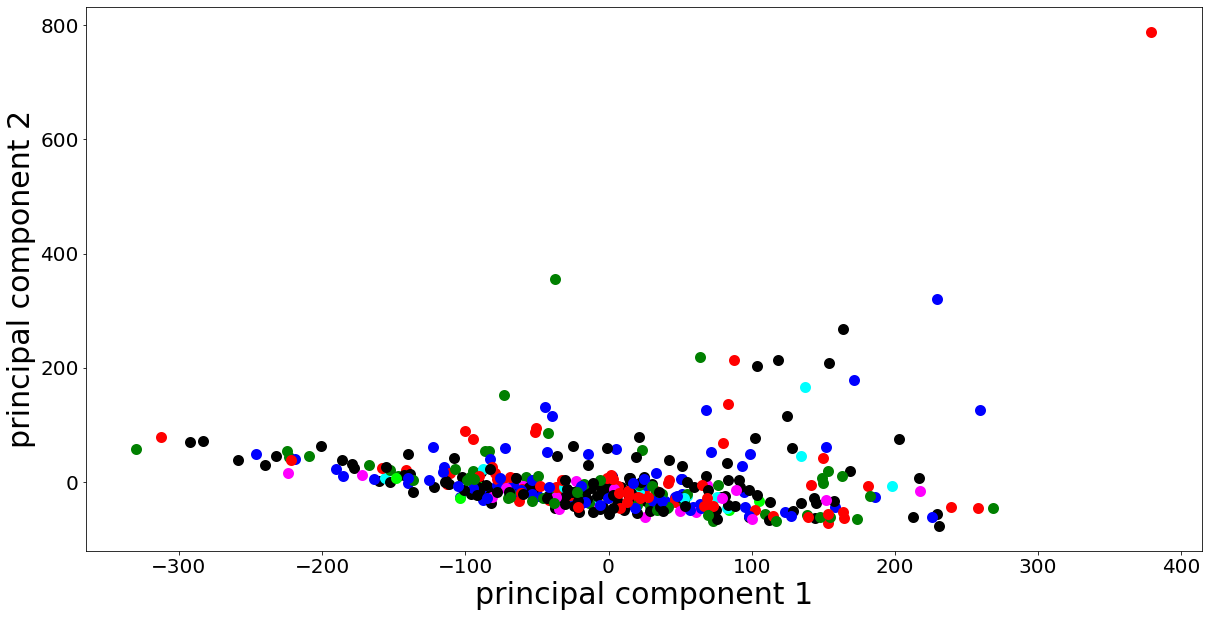

In [95]:
colors ={'Tubular adenocarcinoma': 'red',
         'Carcinoma, diffuse type': 'green',
         'Adenocarcinoma, NOS': 'black',
         'Mucinous adenocarcinoma': 'magenta',
         'Adenocarcinoma with mixed subtypes': 'yellow',
         'Adenocarcinoma, intestinal type': 'blue',
         'Signet ring cell carcinoma': 'cyan',
         'Papillary adenocarcinoma, NOS': 'lime'
         }
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot()
for i in range(len(finalDf)):
  ax.scatter(finalDf['principal component 1'][i], finalDf['principal component 2'][i], color = colors[finalDf['primary_diagnosis.diagnoses'][i]], linewidth=5)

plt.xlabel('principal component 1', fontsize=30)
plt.ylabel('principal component 2', fontsize=30)
plt.tick_params(axis='both', labelsize=20)
plt.show()

Видим, чт кластеризации нет, так как все типы опухолей расположены вперемешку.  

Для того, чтобы понять, какие значения являются выбросами построим гистограммы для каждой из компонент и посчитаем стандартное отклонение. Далее найдём значение отклонения, начиная с которого количесвто точек попавших за это значение < 0.5. Т.е. берём вероятность попасть в граничное значеение умножаем на число общее число точек (407) и сравниваем с 0.5. Зелёным на гистограмме показана ввероятность, соответсвующая этой границе

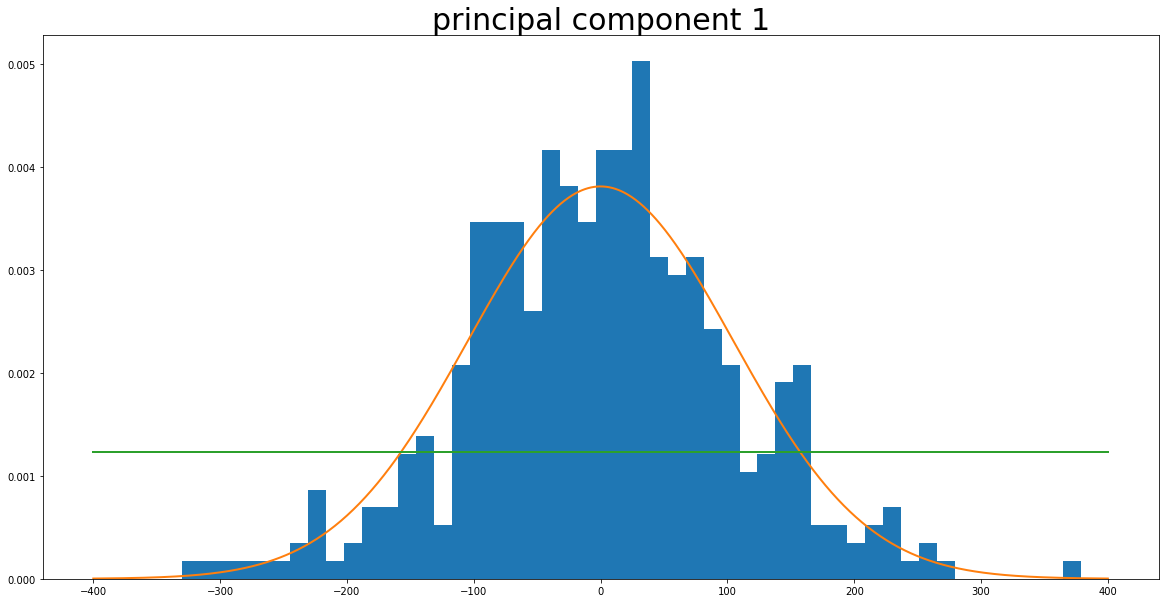

In [96]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot()
x = np.linspace(-400, 400, 1000)
hor = np.array([0.00123]*1000)
y = stats.norm.pdf(x, loc = 0, scale = finalDf['principal component 1'].std()) 

ax.hist(finalDf['principal component 1'], bins = 50, density=True) 
ax.plot(x,y, linewidth = 2)
ax.plot(x,hor, linewidth = 2)
plt.title('principal component 1', fontsize = 30)
plt.show()

In [97]:
from scipy import special
from scipy.optimize import fsolve

In [98]:
def Fun1(x):
  return stats.norm.pdf(x, loc = 0, scale = finalDf['principal component 1'].std()) - 0.00123

In [99]:
def Fun2(x):
  return stats.norm.pdf(x, loc = 0, scale = finalDf['principal component 2'].std()) - 0.00123

In [100]:
delta_x = fsolve(Fun1,+100 )
delta_x

array([157.42773663])

Повторим те же рассуждения для второй компоненты. Хотя там не очень нормальное распределение

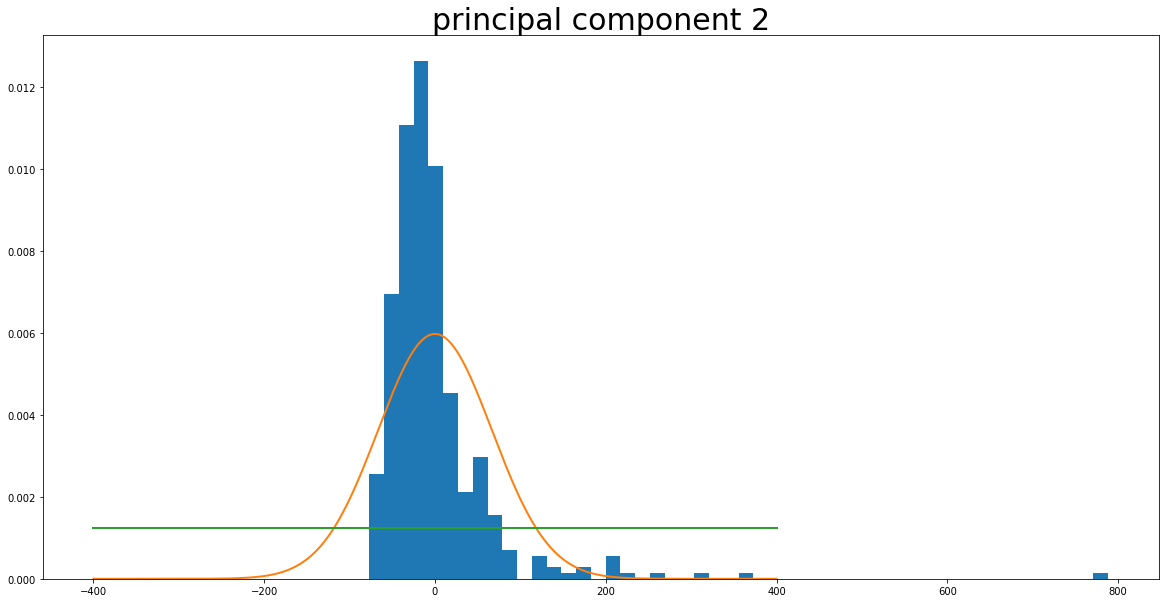

In [101]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot()
x = np.linspace(-400, 400, 1000)
hor = np.array([0.00123]*1000)
y = stats.norm.pdf(x, loc = 0, scale = finalDf['principal component 2'].std()) 

ax.hist(finalDf['principal component 2'], bins = 50, density=True) 
ax.plot(x,y, linewidth = 2)
ax.plot(x,hor, linewidth = 2)
plt.title('principal component 2', fontsize = 30)
plt.show()

In [102]:
delta_x2 = fsolve(Fun2,+100 )
delta_x2

array([118.66673583])

Итого: надо отбросить экземпляры со значениями польше 157 по первой компоненте и 118 по второй. Посмотрим, что осталось и иссследуем это на кластеры на основе экспрессии. 

In [103]:
excess = []
for i in range(len(finalDf)):
  if abs(finalDf['principal component 1'][i]) > 157 or abs(finalDf['principal component 2'][i])> 118 :
    excess.append(finalDf['submitter_id.samples'][i])
    finalDf = finalDf.drop(i, axis = 0)

In [104]:
rest_df = df.drop(columns = excess)
rest_df 

,Ensembl_ID,TCGA-D7-5577-01A,TCGA-D7-6818-01A,TCGA-BR-4280-01A,TCGA-VQ-A91Z-01A,TCGA-HU-A4HD-01A,TCGA-D7-8573-01A,TCGA-BR-7959-01A,TCGA-BR-8679-01A,TCGA-BR-6453-01A,TCGA-BR-A4QL-01A,TCGA-VQ-AA6A-01A,TCGA-HF-7132-01A,TCGA-BR-A4IV-01A,TCGA-CG-5718-01A,TCGA-R5-A7ZR-01A,TCGA-BR-8680-01A,TCGA-VQ-A8P2-01A,TCGA-VQ-A92D-01A,TCGA-HU-A4GT-01A,TCGA-ZA-A8F6-01A,TCGA-D7-A74A-01A,TCGA-IN-A7NR-01A,TCGA-HU-A4H2-01A,TCGA-BR-6456-01A,TCGA-CG-4442-01A,TCGA-CD-8524-01A,TCGA-VQ-A8PO-01A,TCGA-CG-4475-01A,TCGA-HU-A4GH-11A,TCGA-HU-A4GP-01A,TCGA-VQ-A94R-01A,TCGA-VQ-A91E-01A,TCGA-FP-8211-01A,TCGA-D7-A747-01A,TCGA-KB-A93G-01A,TCGA-RD-A8MV-01A,TCGA-BR-4256-01A,TCGA-FP-7735-01A,TCGA-BR-6454-11A,...,TCGA-CG-5716-01A,TCGA-BR-4253-01A,TCGA-BR-8058-01A,TCGA-VQ-A8P3-01A,TCGA-HU-A4H3-01A,TCGA-BR-4267-01A,TCGA-MX-A5UG-01A,TCGA-RD-A8N4-01A,TCGA-CG-5723-01A,TCGA-VQ-AA6D-01A,TCGA-F1-6874-01A,TCGA-CG-4304-01A,TCGA-CG-5733-11A,TCGA-VQ-A8PF-01A,TCGA-BR-8361-01A,TCGA-RD-A7BT-01A,TCGA-CG-5720-11A,TCGA-MX-A5UJ-01A,TCGA-VQ-A91Q-01A,TCGA-D7-5578-01A,TCGA-SW-A7EB-01A,TCGA-HU-A4GU-01A,TCGA-D7-6521-01A,TCGA-IN-AB1V-01A,TCGA-HF-7134-01A,TCGA-CD-A48C-01A,TCGA-HU-8610-01A,TCGA-BR-8373-01A,TCGA-EQ-8122-01A,TCGA-B7-5818-01A,TCGA-D7-A6F2-01A,TCGA-HF-7131-01A,TCGA-CD-5799-01A,TCGA-VQ-A91S-01A,TCGA-HU-8608-01A,TCGA-CD-A489-01A,TCGA-BR-6566-01A,TCGA-BR-A4J6-01A,TCGA-BR-8286-01A,TCGA-CD-8529-01A
0,RP11-368I23.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.196553,0.000000,0.000000,0.000000,0.000000,0.025747,0.000000,0.000000,0.000000,0.117003,0.065701,0.035842,0.000000,0.000000,0.030041,0.195673,0.000000,0.040667,0.000000,0.103966,0.117637,0.000000,0.000000,0.087015,0.024976,0.026188,0.000000,0.053975,0.504675,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.028870,0.030186,0.000000,0.000000,0.127785,0.071320,0.000000,0.000000,0.034431,0.109055,0.000000,0.000000,0.000000,0.000000,0.000000,0.101835,0.000000,0.000000,0.000000,0.000000,0.030281,0.000000,0.000000,0.023201,0.000000,0.000000,0.088569,0.000000,0.029170,0.000000,0.000000,0.000000,0.000000,0.272296,0.000000,0.046976,0.124435,0.028077
1,RP11-742D12.2,0.000000,0.009555,0.000000,0.060100,0.002479,0.016600,0.002234,0.003385,0.011753,0.016503,0.007191,0.000000,0.002773,0.000000,0.000000,0.004656,0.000000,0.006476,0.000000,0.004206,0.000000,0.000000,0.000000,0.000000,0.000000,0.020265,0.003841,0.000000,0.000000,0.003491,0.064537,0.012648,0.000000,0.124849,0.029411,0.004883,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.004041,0.000000,0.039305,0.000000,0.003087,0.010109,0.000000,0.018186,0.028721,0.005230,0.000000,0.000000,0.000000,0.008545,0.000000,0.010939,0.042374,0.000000,0.000000,0.000000,0.000000,0.003983,0.000000,0.000000,0.000000,0.026776,0.003165,0.000000,0.000000,0.000000,0.004721,0.006213,0.000000,0.000000,0.000000,0.000000,0.008988,0.003929
2,RAB4B,3.009860,2.601618,1.621811,1.569297,1.449952,1.315607,1.430888,1.537194,2.848684,1.490224,2.208142,2.105817,1.820941,3.117007,2.441854,1.750760,1.037358,1.225897,1.558169,2.023616,2.404938,1.978388,2.142640,2.285890,1.007680,3.271942,2.274661,2.387475,1.297211,1.768101,1.283142,2.117377,2.127196,1.811135,1.689349,2.254690,1.801106,2.866059,2.667965,...,2.224262,2.411548,1.932723,2.215786,1.519356,1.232833,2.013291,1.319491,2.727122,1.468977,1.842890,2.044319,2.829864,2.455026,1.517085,1.806474,2.757839,2.028487,1.923087,2.492408,2.134615,1.417895,2.578408,2.203971,1.999700,2.730489,2.101663,1.444969,2.256842,2.488889,1.803217,2.586253,2.431977,1.627396,2.125108,1.937515,2.211638,2.583241,2.118506,2.373501
3,AC104183.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.322034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.592916,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

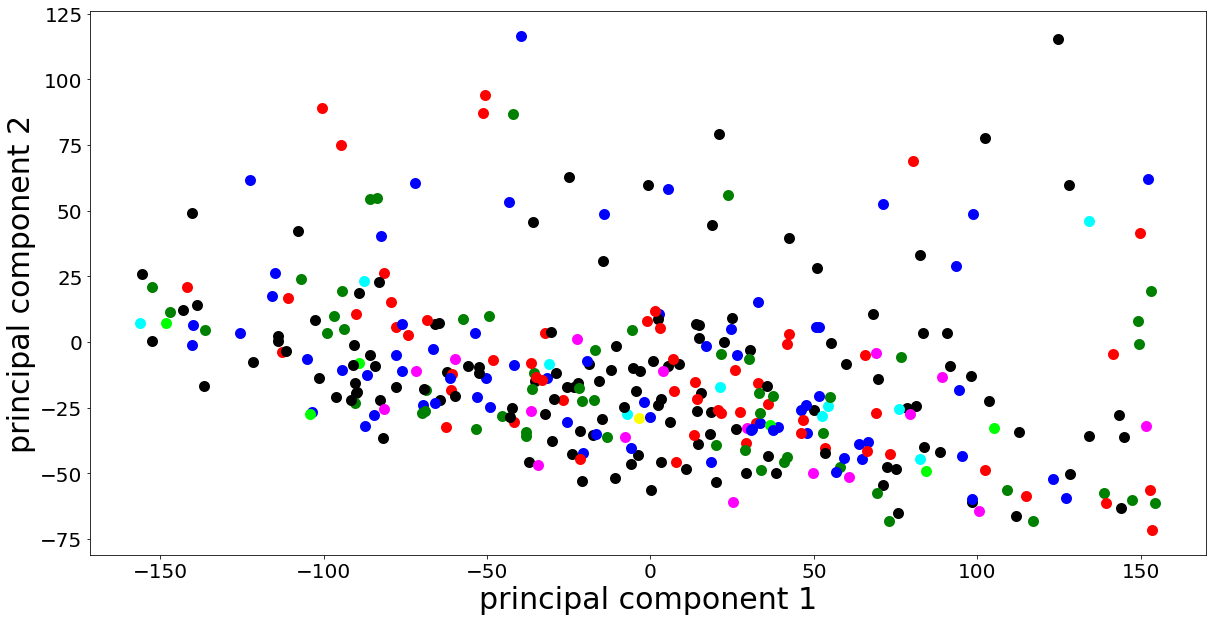

In [105]:
finalDf.index = np.arange(len(finalDf))
finalDf
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot()
for i in range(len(finalDf)):
  ax.scatter(finalDf['principal component 1'][i], finalDf['principal component 2'][i], color = colors[finalDf['primary_diagnosis.diagnoses'][i]], linewidth=5)

plt.xlabel('principal component 1', fontsize=30)
plt.ylabel('principal component 2', fontsize=30)
plt.tick_params(axis='both', labelsize=20)
plt.show()

Теперь посмотрим, будут ли кластеризоваться гены с большой вариацией среди образцов.

In [106]:
genes_cv = rest_df.std(axis = 1)/rest_df.mean(axis = 1)
genes_cv 


0        2.258874
1        2.419811
2        0.240463
3        5.813215
4        0.207957
           ...   
60478    0.135872
60479    0.782032
60480    6.341710
60481    0.500426
60482    2.742234
Length: 60483, dtype: float64

In [107]:
genes_cvdf = pd.DataFrame(genes_cv)
genes_cvdf.columns = ['CV']
genes_cvdf 

,CV
0,2.258874
1,2.419811
2,0.240463
3,5.813215
4,0.207957
...,...
60478,0.135872
60479,0.782032
60480,6.341710
60481,0.500426


In [108]:
new_cv = genes_cvdf.sort_values(by = 'CV', ascending = False, inplace = False)
print(new_cv.head())
genes_with_high_cv = []
for i in new_cv.index:
  genes_with_high_cv.append(i)
  if new_cv['CV'][i] <15:
    break 

print(len(genes_with_high_cv))


              CV
21654  18.574176
4156   18.574176
59894  18.574176
29997  18.574176
58318  18.574176
210


Мы добыли гены с вариабелльностью больше 15. Теперь посмотрим, как распределятся образцы по экспрессиям этих генов.

In [109]:
df6 = rest_df.iloc[genes_with_high_cv]
df6

,Ensembl_ID,TCGA-D7-5577-01A,TCGA-D7-6818-01A,TCGA-BR-4280-01A,TCGA-VQ-A91Z-01A,TCGA-HU-A4HD-01A,TCGA-D7-8573-01A,TCGA-BR-7959-01A,TCGA-BR-8679-01A,TCGA-BR-6453-01A,TCGA-BR-A4QL-01A,TCGA-VQ-AA6A-01A,TCGA-HF-7132-01A,TCGA-BR-A4IV-01A,TCGA-CG-5718-01A,TCGA-R5-A7ZR-01A,TCGA-BR-8680-01A,TCGA-VQ-A8P2-01A,TCGA-VQ-A92D-01A,TCGA-HU-A4GT-01A,TCGA-ZA-A8F6-01A,TCGA-D7-A74A-01A,TCGA-IN-A7NR-01A,TCGA-HU-A4H2-01A,TCGA-BR-6456-01A,TCGA-CG-4442-01A,TCGA-CD-8524-01A,TCGA-VQ-A8PO-01A,TCGA-CG-4475-01A,TCGA-HU-A4GH-11A,TCGA-HU-A4GP-01A,TCGA-VQ-A94R-01A,TCGA-VQ-A91E-01A,TCGA-FP-8211-01A,TCGA-D7-A747-01A,TCGA-KB-A93G-01A,TCGA-RD-A8MV-01A,TCGA-BR-4256-01A,TCGA-FP-7735-01A,TCGA-BR-6454-11A,...,TCGA-CG-5716-01A,TCGA-BR-4253-01A,TCGA-BR-8058-01A,TCGA-VQ-A8P3-01A,TCGA-HU-A4H3-01A,TCGA-BR-4267-01A,TCGA-MX-A5UG-01A,TCGA-RD-A8N4-01A,TCGA-CG-5723-01A,TCGA-VQ-AA6D-01A,TCGA-F1-6874-01A,TCGA-CG-4304-01A,TCGA-CG-5733-11A,TCGA-VQ-A8PF-01A,TCGA-BR-8361-01A,TCGA-RD-A7BT-01A,TCGA-CG-5720-11A,TCGA-MX-A5UJ-01A,TCGA-VQ-A91Q-01A,TCGA-D7-5578-01A,TCGA-SW-A7EB-01A,TCGA-HU-A4GU-01A,TCGA-D7-6521-01A,TCGA-IN-AB1V-01A,TCGA-HF-7134-01A,TCGA-CD-A48C-01A,TCGA-HU-8610-01A,TCGA-BR-8373-01A,TCGA-EQ-8122-01A,TCGA-B7-5818-01A,TCGA-D7-A6F2-01A,TCGA-HF-7131-01A,TCGA-CD-5799-01A,TCGA-VQ-A91S-01A,TCGA-HU-8608-01A,TCGA-CD-A489-01A,TCGA-BR-6566-01A,TCGA-BR-A4J6-01A,TCGA-BR-8286-01A,TCGA-CD-8529-01A
21654,MIR7855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.274515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4156,TSPY19P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
59894,SNORD37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.585530,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
29997,MIR548AG1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.585530,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
58318,AC026305.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27438,CSH1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.657354,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.014035,0.044032,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042106,0.0,0.0,0.0,0.0
10046,AC016706.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.

In [118]:
df6 = rest_df.iloc[genes_with_high_cv]
df6 = df6.drop(labels = 'Ensembl_ID', axis = 1)
df6 = df6.transpose()
#Нормируем и центрируем
df6 = df6.sub(df6.mean(axis = 1), axis = 'index')
for i in df6.columns:
  df6[i] = df6[i]/df6[i].std()

df6

,21654,4156,59894,29997,58318,22256,29855,59327,28866,58062,48534,23466,33774,13604,26911,6372,4421,44605,17307,7204,25371,17243,56333,27825,12936,37452,19673,13226,50740,14770,1058,57624,31504,5196,28559,36602,19869,21880,4979,3127,...,40989,30875,6315,49604,52745,31948,1634,19640,21687,47174,41059,10178,50535,32071,31115,37715,44842,9702,27598,33172,27885,51003,42249,48739,6219,49642,38614,11611,56199,24792,46934,57379,47441,53362,41415,27438,10046,10443,54270,510
TCGA-D7-5577-01A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-D7-6818-01A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-BR-4280-01A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-VQ-A91Z-01A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-HU-A4HD-01A,-0.006534,-0.019519,-0.003320,-0.003320,-0.007198,-0.006499,-0.002473,-0.020449,-0.006458,-0.004353,-0.016455,-0.009209,-0.018544,-0.005125,-0.018484,-0.018210,-0.005155,-0.009172,-0.006131,-0.006295,-0.018354,-0.017075,-0.005272,-0.007573,-0.005559,-0.018736,-0.020051,-0.003257,-0.020422,-0.015840,-0.020519,-0.004094,-0.008195,-0.020519,-0.018616,-0.009761,-0.010728,-0.004308,-0.020527,-0.019031,...,-0.017370,-0.007932,-0.002872,-0.008957,-0.005738,-0.018330,-0.016375,-0.020466,-0.015811,-0.006998,-0.007697,-0.007120,-0.008147,-0.020097,-0.0

In [120]:
principalComponents6 = pca_object.fit_transform(df6)
principalDf6 = pd.DataFrame(data = principalComponents6
             , columns = ['principal component 1', 'principal component 2'])
principalDf6

,principal component 1,principal component 2
0,-1.751625,-0.087589
1,-1.751625,-0.087589
2,-1.751625,-0.087589
3,-1.751625,-0.087589
4,-1.570302,-0.087670
...,...,...
340,-1.393717,-0.089520
341,-1.751625,-0.087589
342,-2.356421,-0.115978
343,-2.687922,-0.127562


In [121]:
finalDf6 = pd.concat([principalDf6, pd.Series(df6.index)], axis = 1)
finalDf6.columns = ['principal component 1', 'principal component 2', 'submitter_id.samples']
finalDf6

,principal component 1,principal component 2,submitter_id.samples
0,-1.751625,-0.087589,TCGA-D7-5577-01A
1,-1.751625,-0.087589,TCGA-D7-6818-01A
2,-1.751625,-0.087589,TCGA-BR-4280-01A
3,-1.751625,-0.087589,TCGA-VQ-A91Z-01A
4,-1.570302,-0.087670,TCGA-HU-A4HD-01A
...,...,...,...
340,-1.393717,-0.089520,TCGA-CD-A489-01A
341,-1.751625,-0.087589,TCGA-BR-6566-01A
342,-2.356421,-0.115978,TCGA-BR-A4J6-01A
343,-2.687922,-0.127562,TCGA-BR-8286-01A


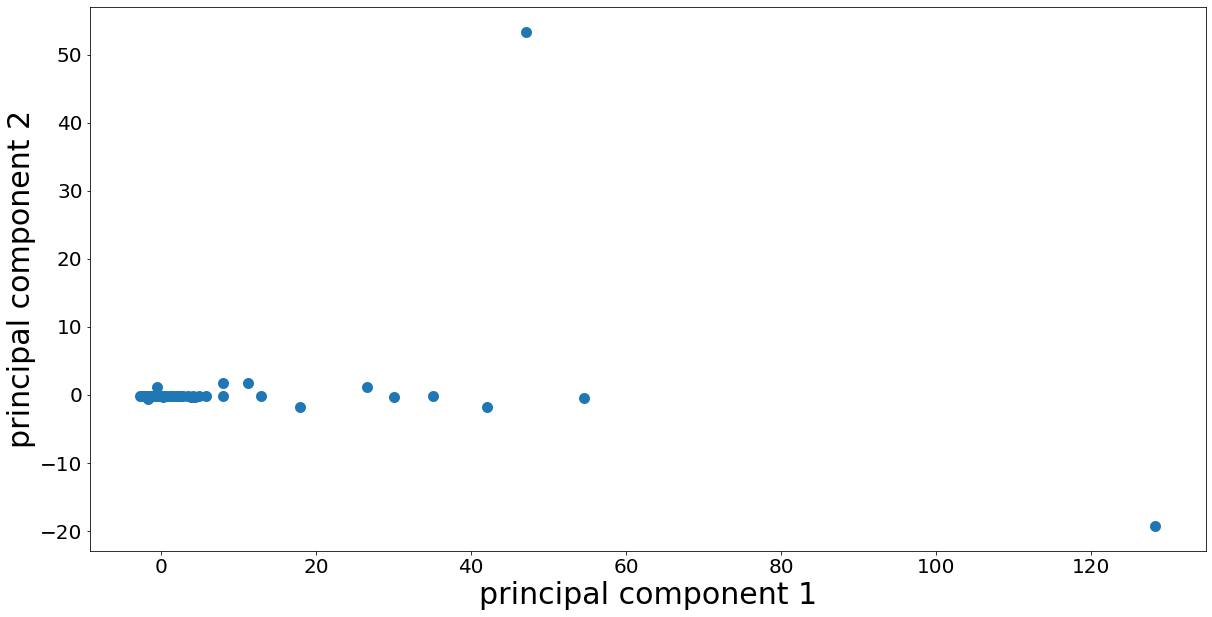

In [122]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot()
ax.scatter(finalDf6['principal component 1'], finalDf6['principal component 2'], linewidth=5)

plt.xlabel('principal component 1', fontsize=30)
plt.ylabel('principal component 2', fontsize=30)
plt.tick_params(axis='both', labelsize=20)
plt.show()

Видно, что у нас существенно отличаются 12 образцов. Посмотрим на них внимательней. Для этого найдём гены, дающие основной вклад в первую компоненту

In [123]:
#Это просто вспомнить, как от номера переходить к ID
num_gene = rest_df.iloc[genes_with_high_cv]['Ensembl_ID']
num_gene

21654          MIR7855
4156           TSPY19P
59894          SNORD37
29997        MIR548AG1
58318       AC026305.1
             ...      
27438             CSH1
10046       AC016706.1
10443           TSPY7P
54270            TSPY1
510      RP11-293I14.2
Name: Ensembl_ID, Length: 210, dtype: object

In [124]:
pca = PCA(n_components=2)
pca.fit_transform(df6)
pc1 = np.array(pca.components_[0,:])
first5 = []
last5 = []
for i in range(5):
  maxind = pc1.argmax()
  max_gene_num = df6.columns[maxind]
  first5.append(num_gene[max_gene_num])
  pc1 = np.delete(pc1, maxind)

  minind = pc1.argmin()
  min_gene_num = df6.columns[minind]
  last5.append(num_gene[min_gene_num])
  pc1 = np.delete(pc1, minind)

print('Гены дающие положительный вклад в PC1:',first5, '\n', 'Гены дающие отрицательный вклад в PC1:',last5)


Гены дающие положительный вклад в PC1: ['TSPY1', 'TSPY3', 'AL359955.1', 'TSPY10', 'UBE2Q2P8'] 
 Гены дающие отрицательный вклад в PC1: ['OPN1MW', 'RP11-1236K1.11', 'USP17L18', 'USP17L15', 'AL390335.1']


Гены TSPY участвуют в клеточной дифференциации и сборке нуклеосом.  

AL359955.1 и UBE2Q2P8 согласно Ensemble являются псевдогенами. 

OPN1MW отвечает за цветное зрение. 

RP11-1236K1.11 - псевдоген. 

USP17L18 - деубиквитинирующий фермент, для регулирования различных клеточных процессов, которые могут включать пролиферацию клеток, прохождение клеточного цикла, апоптоз, миграцию клеток и клеточный ответ на вирусную инфекцию.

Про AL390335.1 нашёл только то, что он кодирует miRNA

Получается, что в образцах перечисленных ниже, наблюдается высокая эксперессия псеевдогенов и малая USP17L18. Из-за чего, возможно, раковые клетки не уходят в апоптоз. 



In [125]:
interesting_samples = finalDf6[finalDf6['principal component 1'] >7.5 ]['submitter_id.samples']
interesting_samples.index

Int64Index([33, 70, 85, 114, 173, 175, 190, 198, 224, 239, 273, 291], dtype='int64')

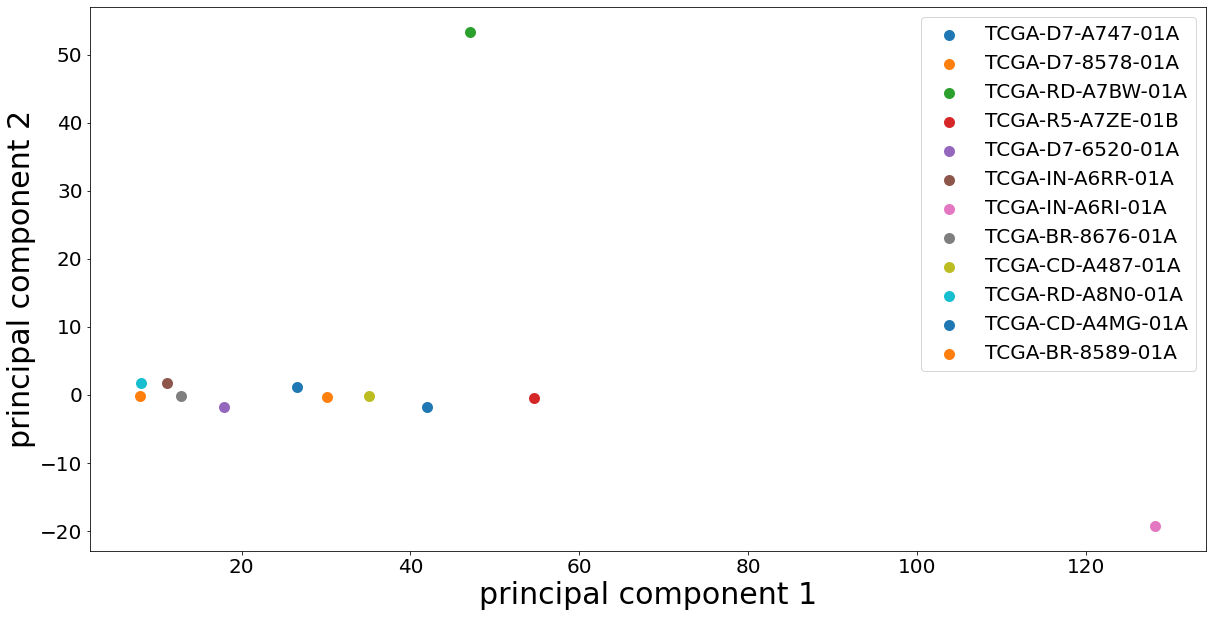

In [126]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot()
for i in interesting_samples:
  ax.scatter(finalDf6[finalDf6['submitter_id.samples'] == i ]['principal component 1'], finalDf6[finalDf6['submitter_id.samples'] == i ]['principal component 2'], 
             label = i, linewidth=5)

plt.xlabel('principal component 1', fontsize=30)
plt.ylabel('principal component 2', fontsize=30)
plt.tick_params(axis='both', labelsize=20)
plt.legend(fontsize=20)
plt.show()

Кластеризовать получилось бы лучше, если бы удалось приписать всем образцам дискретный параметр, и по нему уже красить точки на PCA-plot. Но на основе непрерывной экспрессии я не смог придумать такого парметра. 

Я попробовал найти что-нибудь подходящее в фенотипах для этих 12-ти экземпляров. Но не нашёл ничего, выделяющего их на фоне всех остальных.

Гермлайновые мутации - это мутации, происходящие в клетках зародышего пути, т.е. клетках, дающих начало гаметам. А соматические мутации, соответсвенно - в остальных клетках. Главное отличие заключается в том, что если мутация гермлайновая, то она передастся в следующее поколение и будет налюдаться во всех клетках дочернего организма. Это как раз таки спосов понять, яляется ли мутация обнаруженная в некоторой ткани соматической или пришла от родителя. Если у родителя эта мутация не обнаруживается в соматических клетках, то она появилась именно в этом поколении. Иначе надо копать глубже в филогенетическое древо.

Из того, что существует наследственная форма рака желудка, можно сделать вывод, что существуют гермлайновые мутации, ассоциированные с ним. Показаниями к проверке на них являются ранний возраст развития рака у роственника, частые случаи в семье в одной линии. 

Дальше посмотрим на копийность сегментов генов исследуемых образцов. На рисунке представлен процент сегметов с хромосомы, копийность которых увеличилась (красное) и уменьшилась (синее). 

In [127]:
with gzip.open('TCGA-STAD.cnv.tsv.gz', 'r') as f:
  CNV = pd.read_csv(f, sep ='\t')
CNV['Start'] = pd.to_numeric(CNV['Start'])
CNV['End'] = pd.to_numeric(CNV['End'])
CNV['value'] = pd.to_numeric(CNV['value'])
CNV

,sample,Chrom,Start,End,value
0,TCGA-VQ-A8PO-01A,1,62920,888756,0.2566
1,TCGA-VQ-A8PO-01A,1,901333,1251144,-0.2934
2,TCGA-VQ-A8PO-01A,1,1251206,2084400,-0.0281
3,TCGA-VQ-A8PO-01A,1,2092625,3301765,-0.3131
4,TCGA-VQ-A8PO-01A,1,3302046,5838263,-0.0847
...,...,...,...,...,...
312982,TCGA-BR-8682-01A,X,133864846,133910787,0.7466
312983,TCGA-BR-8682-01A,X,133911309,141151124,-0.0063
312984,TCGA-BR-8682-01A,X,141151277,141153309,-2.6289
312985,TCGA-BR-8682-01A,X,141154218,155952689,-0.0044


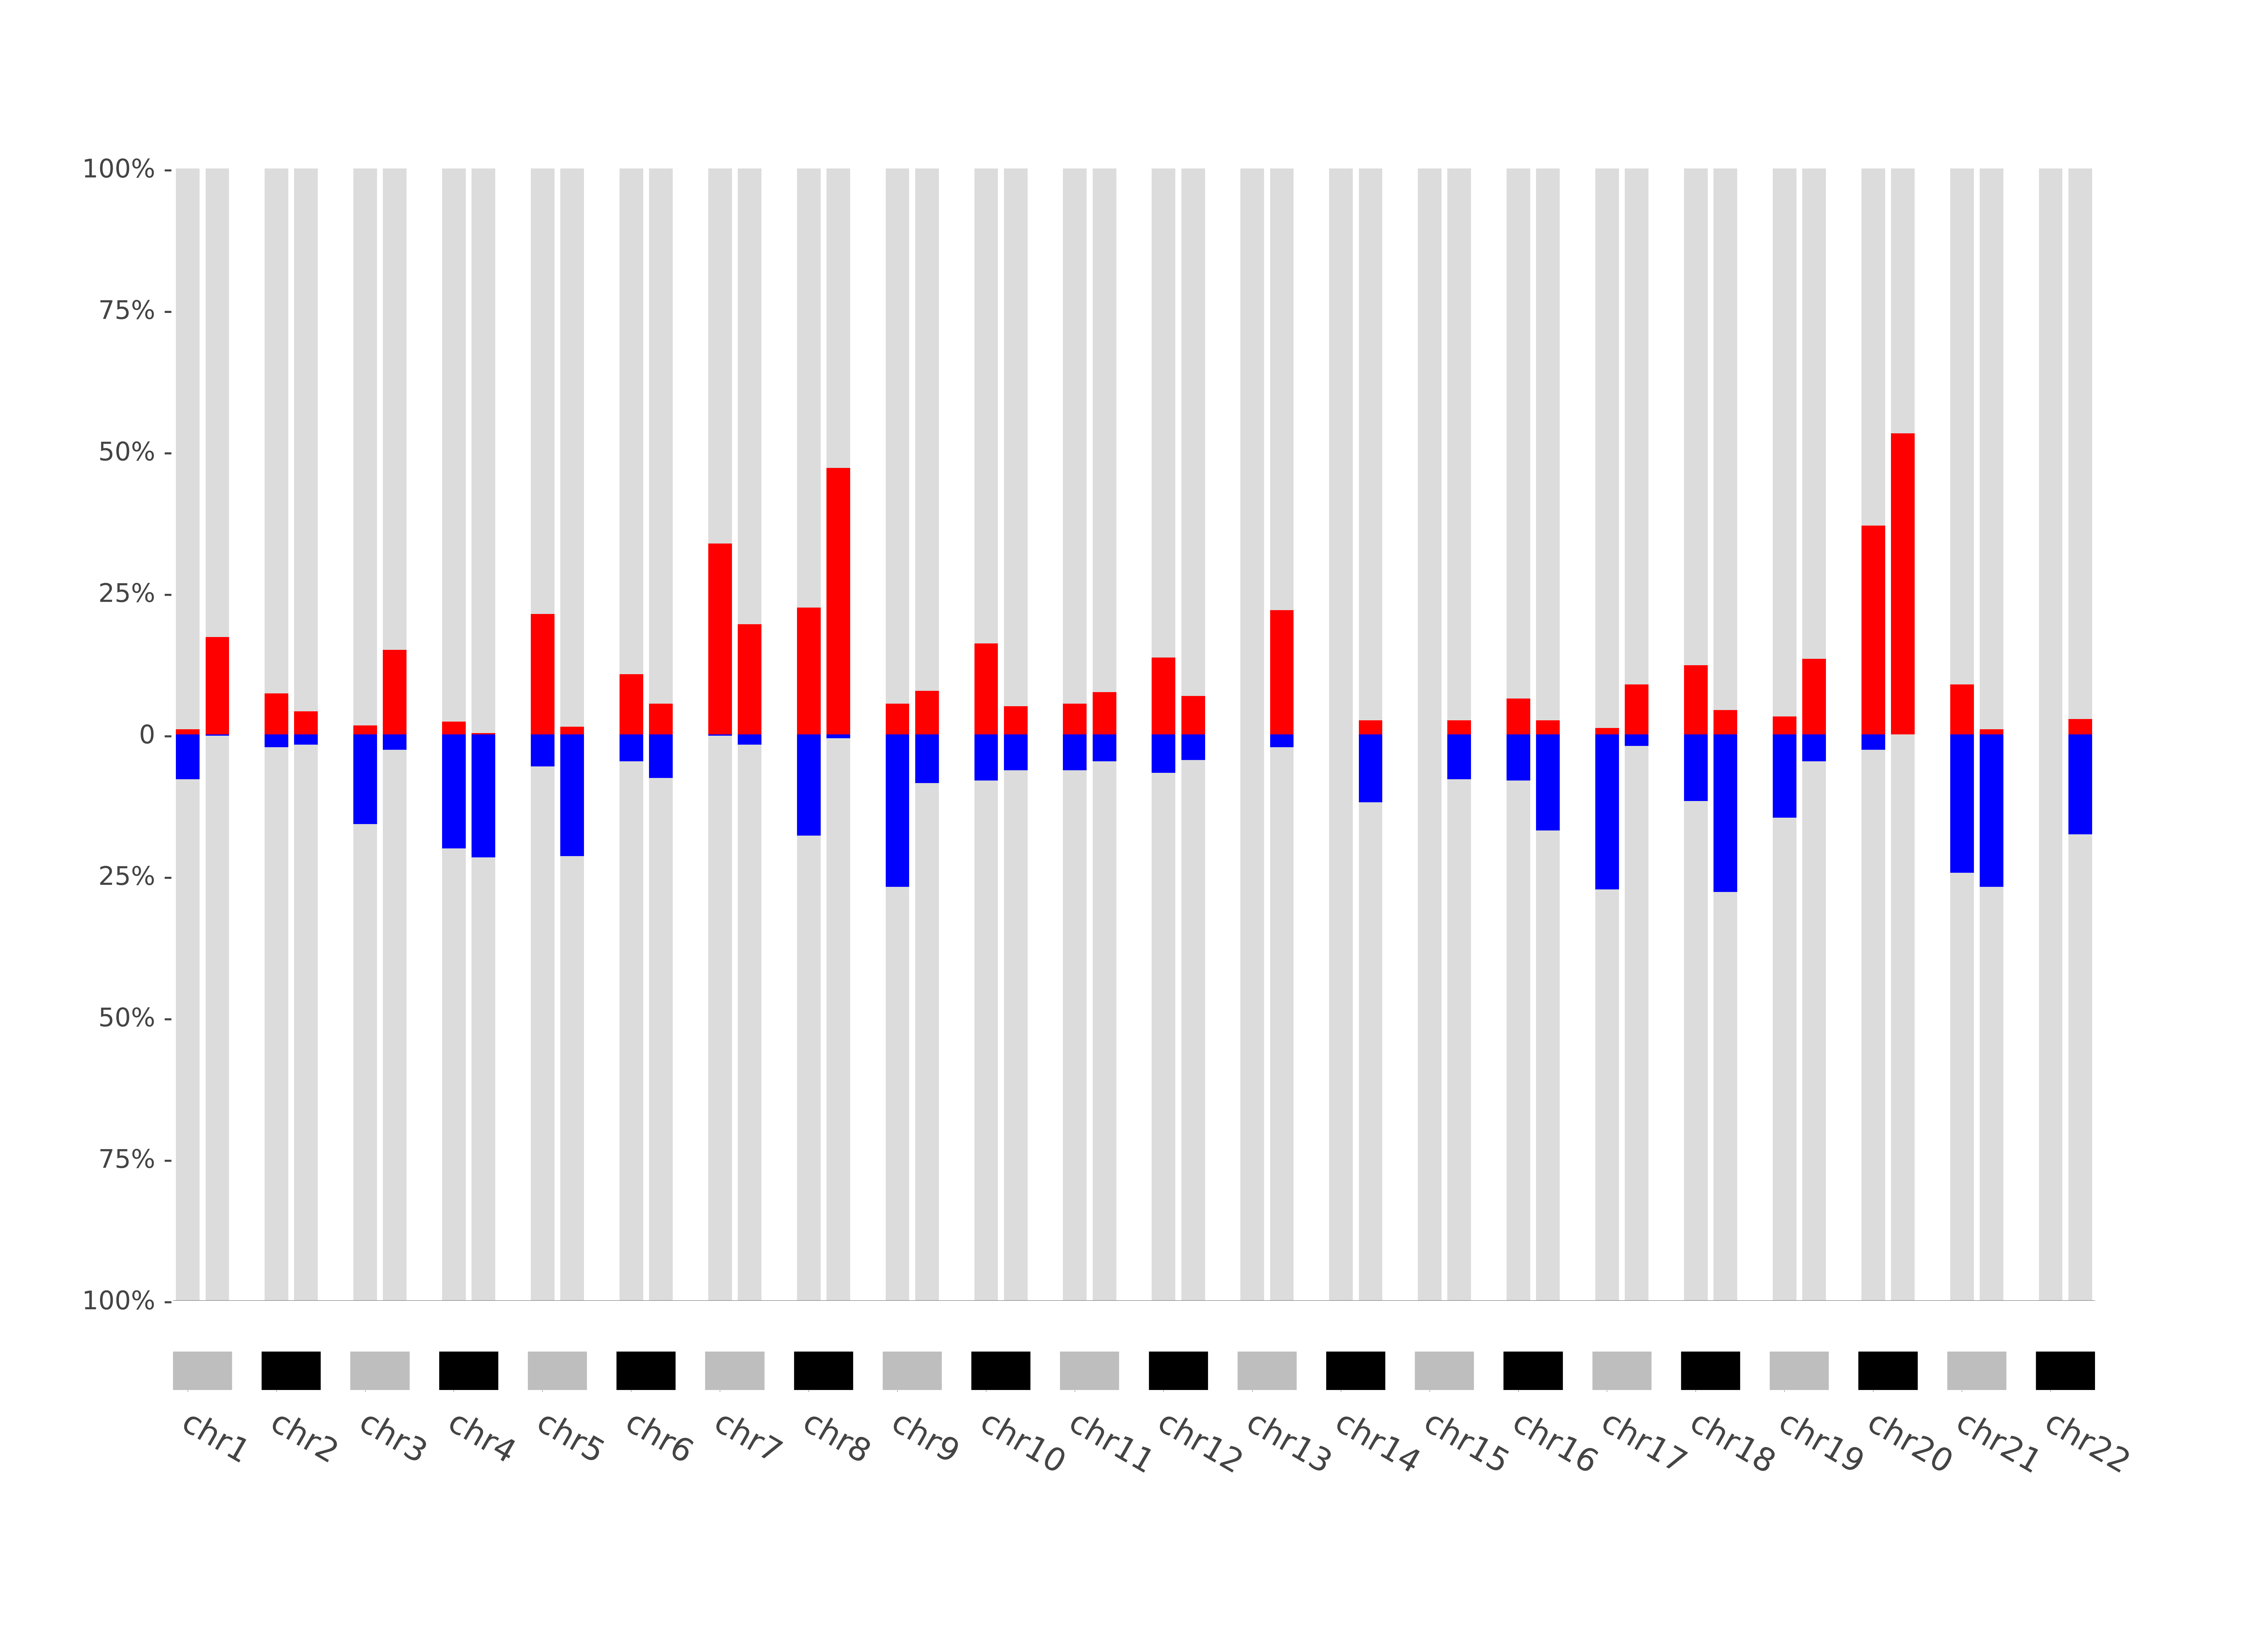

In [128]:
from IPython.display import Image
Image(filename ='region_frequencies_Arms_2021-04-26 09_31_14.png', width=1200, height=700)

Посмотрим на копийность генов, перечисленных в начале работы. Для этого нам нужно их положение в геноме.

COL1A1 - Chr 17: 50,184,101-50,201,632 

COL1A2 - Chr 7: 94,394,895-94,431,227

COL3A1 - Chr 2: 188,974,373-189,012,746

CAS - Chr 20: 49,046,246-49,096,960

HMGA1 - Chr 6: 34,236,873-34,246,231

DHDH - Chr 19: 48,933,699-48,944,969

RNASE1 - Chr 14: 20,801,228-20,802,855

EZR - Chr 6: 158,765,741-158,819,368



In [129]:
locs = {'COL1A1':(17, 50184101, 50201632),
        'COL1A2':(7, 94394895, 94431227),
        'COL3A1': (2, 188974373, 189012746),
        'CAS': (20, 49046246, 49096960),
        'HMGA1': (6, 34236873, 34246231),
        'DHDH': (19, 48933699, 48944969),
        'RNASE1' : (14, 20801228, 20802855),
        'EZR' : (6, 158765741, 158819368)
        }

In [130]:
for i in locs:
  ans = CNV[ (CNV['Chrom'] == str(locs[i][0])) & (CNV['Start'] <locs[i][1]) & (CNV['End']>locs[i][2]) ]['value'].sum()
  print('Суммарное изменение копийности гена', i,' =', ans)

Суммарное изменение копийности гена COL1A1  = 13.3975
Суммарное изменение копийности гена COL1A2  = 67.6315
Суммарное изменение копийности гена COL3A1  = 9.4026
Суммарное изменение копийности гена CAS  = 117.36930000000001
Суммарное изменение копийности гена HMGA1  = 11.4648
Суммарное изменение копийности гена DHDH  = 10.727799999999998
Суммарное изменение копийности гена RNASE1  = -9.9188
Суммарное изменение копийности гена EZR  = -8.493000000000002


Почти всё сошлось со сказынным в начале. Еденственное отличие наблюдается в гене DHDH: его копийность увеличена, хотя экспрессия должна быть меньше. Но в целом такое возможно, если, например, не будет транскрипционных факторов на него.

Я не смог построить теплокарту для копийности участков генома, так как заводить по каджому образцу массив на 3*10^9 элементов, показывающий копийность отдельных пар осований - это плохая идея. А тулов работающих с текущим форматом я не нашёл(
  
Для ответа на последний вопрос посмотрим отношение суммарной длины генов изменённой копийности к длине генома.

In [131]:
residual = CNV[['sample', 'End']].copy()
residual['End'] =  residual['End'] - CNV['Start']

names = set()
for i in CNV['sample']:
   names.add(i)
names = list(names)
changed_len = []
for i in names:
  changed_len.append(residual[ residual['sample'] == i]['End'].sum() / 3088286401)



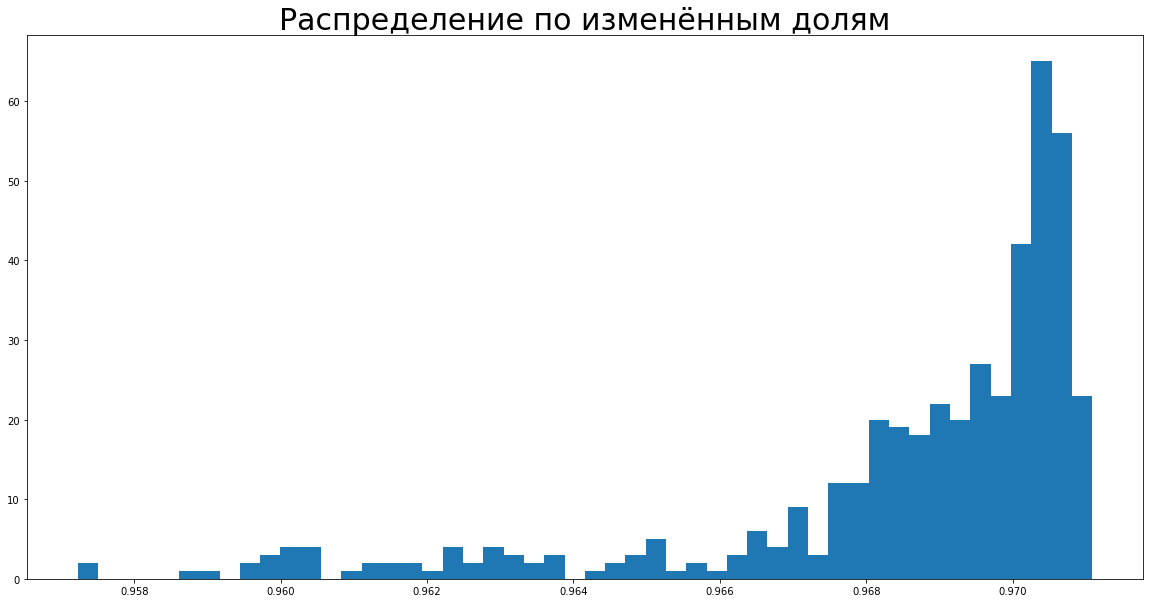

In [132]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot()

ax.hist(changed_len, bins = 50) 
plt.title('Распределение по изменённым долям', fontsize = 30)
plt.show()

Как видно из гистограммы изменение копийности встречается очень часто (если вопрос был про наши образцы). То есть больше 95% генома претерпело изменение копийности